In [1]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim 
import torch.nn as nn
import torch

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torchvision
import math
import time
import cv2 
import sys
import os

sys.path.insert(0, "../torchvf/")
from dataloaders import *
from transforms import *
from numerics import *
from losses import *
from utils import *

from sklearn.cluster import DBSCAN

In [2]:
DATA_DIR  = "../data/bpcis/"
VF_DELIM  = "_vf_10_11"
DEVICE    = "cuda:0"

In [3]:
def visualize(image, mask, vf):
    fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize = (200, 40))
    ax0.imshow(image)
    ax1.imshow(vf[0])
    ax2.imshow(vf[1])
    ax3.imshow(np.linalg.norm(vf, axis = 0))
    ax4.imshow(mask)
    plt.show()

In [4]:
train_dataset = BPCIS(
    DATA_DIR, 
    split = "bact_fluor_train", 
    transforms = None
)
train_dataloader = DataLoader(
    train_dataset, 
    batch_size = 1, 
    drop_last = False,
    shuffle = False,
)

In [5]:
test_dataset = BPCIS(
    DATA_DIR, 
    split = "bact_fluor_test",  
    transforms = None
)
test_dataloader = DataLoader(
    test_dataset, 
    batch_size = 1, 
    drop_last = False,
    shuffle = False,
)

In [6]:
train_save_dir = train_dataset.split_dir
train_save_dir

'../data/bpcis/bact_fluor_train'

  0%|                                                                                                                                                                                      | 0/143 [00:00<?, ?it/s]/home/ryan/.local/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


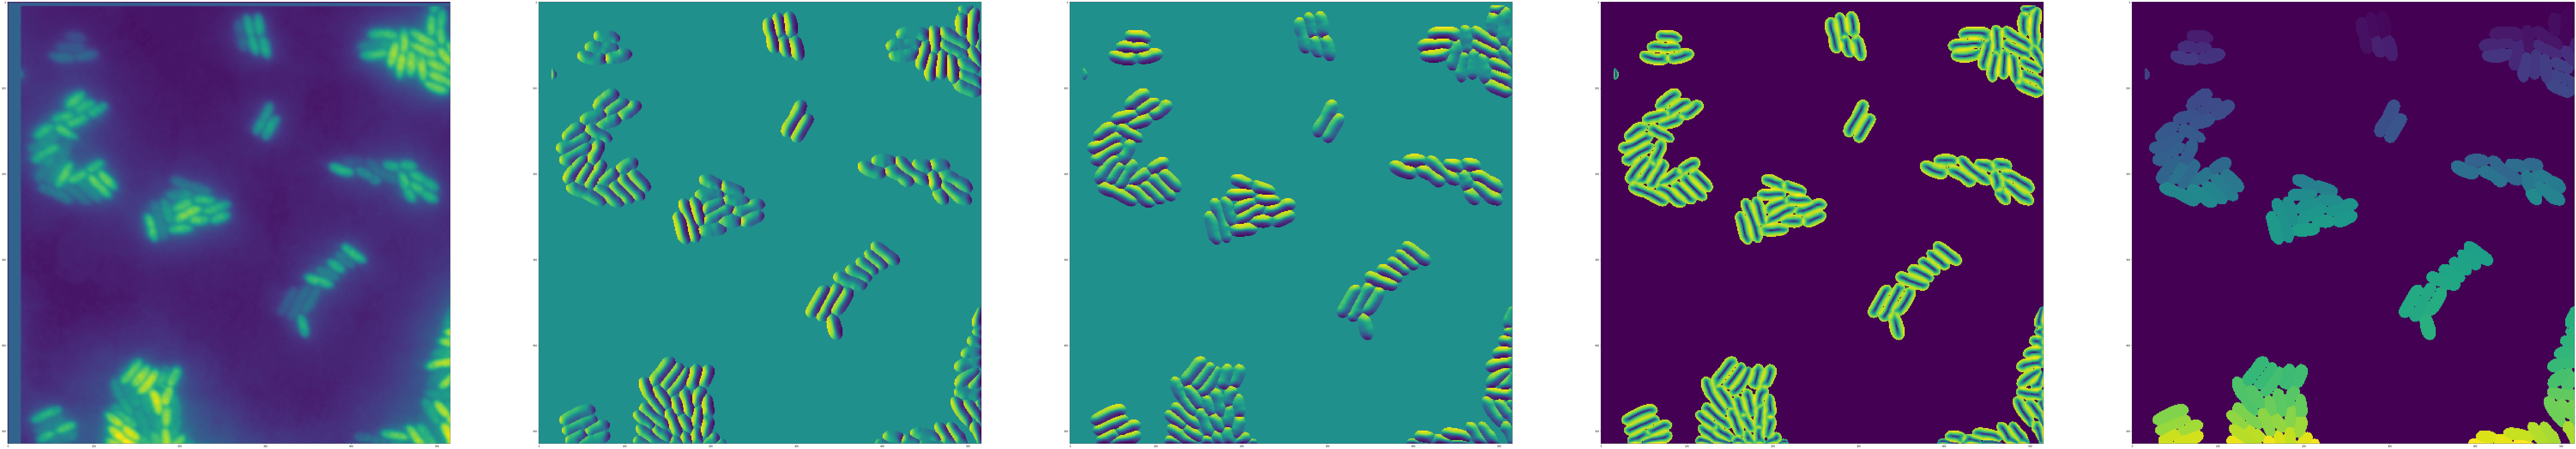

  0%|                                                                                                                                                                                      | 0/143 [00:04<?, ?it/s]


In [7]:
alpha = 10
kernel_size = 11
for step, (image, mask) in enumerate(tqdm(train_dataloader)):
    image = image.to(DEVICE).float()
    mask  = mask.to(DEVICE).int()

    _, _, H, W = image.shape

    vf = compute_vector_field(
        mask[0], 
        kernel_size, 
        alpha = alpha,
        device = "cuda"
    )

    #semantic = mask > 0
    #f = build_f(vf, mode = "bilinear") 
    #init_values = init_values_semantic(semantic, device = "cpu")
    #solutions = ivp_solver_single(f, init_values, dx = 0.25, n_steps = 8, solver = "euler")
    #fig = plt.figure(figsize = (20, 20))
    #plt.scatter(x = solutions[0], y = solutions[1], s = 0.05)
    #plt.show()
        
    image = image.cpu().numpy()[0][0].astype(np.uint8)
    mask  = mask.cpu().numpy()[0][0].astype(np.uint16)
    vf    = vf.cpu().numpy().astype(np.float32)
    
    visualize(image, mask, vf)
    break
    
    old_filename = train_dataset.imgs[step]
   
    new_vf_filename = os.path.basename(old_filename).replace("_img.tif", f"{VF_DELIM}.npy")
    new_vf_dir      = os.path.join(train_save_dir, new_vf_filename)
    
    new_image_dir = os.path.join(train_save_dir, os.path.basename(old_filename))
    new_mask_dir  = new_image_dir.replace("_img.tif", f"_masks.tif")

    #print(image.shape)
    #print(mask.shape)
    #print(vf.shape)
    #print(new_vf_dir)
    #print(new_image_dir)
    #print(new_mask_dir) 
    #break

    np.save(new_vf_dir, vf)
    #cv2.imwrite(new_mask_dir, mask)
    #cv2.imwrite(new_image_dir, image)